### Nika Mosayebi Behrooz &emsp; 810196562 &emsp; CA4

We have a dataset which includes some stores' customers' features, like the customer's country, the shopping date, total price and ... . In this CA, we want to use different classifiers using SciKit-Learn library and train models to predict whether a customer goes back to a store or not.

In [501]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category = UndefinedMetricWarning)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

### Preprocess:

We should turn raw data into processable features. First of all we separate target values from features. Now we have to apply different preprocesses to each type of feature. <br><br>
There are many methods for handling categorical features such as country. Two of the most commom approaches are "Label Encoding" and "One-Hot Encoding". Label encoding maps each category to a number. The problem with this approach is that we're creating an order while the categorical data doesn't necessarily have an order. For example, in our case, it doesn't make sense to assign values such that Australia is less than United Kingdom. The danger in Label Encoding is that our algorithm may learn to favor some categories over the others due to the ordinal values that we assigned them during encoding. <br>
One-Hot Encoding is a common alternative approach for handling categorical data. In this method, we create a column for each category and assign 1 or 0 to each column. These columns are known as dummies and it's like each column is a new feature. This has the benefit of not weighting a value improperly but has the downside of adding many columns to the dataset. In this case, we don't have too many unique values for country, so there's no problem. <br><br>
We also need to preprocess date variables. From a date variable, we can extract many features like year, quarter, month, day of the month, day of the week and ... . I extracted different features from date in this problem, and found some of them, such as day of the month and month, more important than the others. <br><br>
At this point, we should consider whether or not some method of data normalization will be beneficial for our algorithm. The preprocessed data may contain features with a mixture of scales. Feature scaling allows all features to contribute relative to their importance rather than their scale. Some  machine learning algorithms like KNN and Logistic Regression, require feature scaling but for some algorithms like Decision Tree, it's optional and yet not essential. There's a few different methods for scaling features. Min-max scalers and standard scalers are the most commonly used approaches. Min-max scaling transforms values to wanted ranges. For example, it sets the lowest observed value to 0 and the highest observed value to 1, so all features will be between 0 and 1 after scaling. Standard scaling standardizes features by removing the mean and scaling to unit variance.

In [502]:
def separateFeaturesFromLabels(dataFileName, targetName):
    data = pd.read_csv(dataFileName, index_col = 0)
    features = data.drop(targetName, 1)
    labels = data[targetName]
    return features, labels

In [503]:
def preprocess(features, labels):   
    features1 = features
    oneHotEncodedCountry = pd.get_dummies(features1["Country"])
    features1 = features1.drop("Country", 1)
    features1[oneHotEncodedCountry.columns] = pd.DataFrame(oneHotEncodedCountry.values, index = features1.index)
    features1["Date"] = pd.to_datetime(features1["Date"])
    features1["Year"] = features1["Date"].dt.year
    features1["Month"] = features1["Date"].dt.month
    features1["Day of Month"] = features1["Date"].dt.day
    features1 = features1.drop("Date", 1)
    stdScaler = StandardScaler()
    features1[["Customer ID", "Total Quantity", "Total Price", "Purchase Count", "Year", "Month", "Day of Month"]] =\
     stdScaler.fit_transform(features1[["Customer ID", "Total Quantity", "Total Price", "Purchase Count", "Year", "Month", "Day of Month"]])
    print(features1)
    labelEncoder = LabelEncoder()
    labels = labelEncoder.fit_transform(labels)
    print(labels)
    return features1, labels

In [504]:
def informationGainCalc(features, labels):
    numOfFeatures = len(features.columns)
    discFeatures = [True] * numOfFeatures
    discFeatures[2] = False
    informationGains = mutual_info_classif(features, labels, discrete_features = discFeatures, copy = True)
    return informationGains

In [505]:
def overSample(trainFeatures, trainLabels):
    ros = RandomOverSampler(random_state = 0)
    trainFeaturesResampled, trainLabelsResampled = ros.fit_resample(trainFeatures, trainLabels)
    return trainFeaturesResampled, trainLabelsResampled

In [506]:
def KNN(trainFeatures, testFeatures, trainLabels, testLabels, numOfNeighbors):
    model = KNeighborsClassifier(n_neighbors = numOfNeighbors)
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [507]:
def helpFindBestKNN(trainFeatures, testFeatures, trainLabels, testLabels):
    trainAccuracyList = []
    testAccuracyList = []
    for numOfNeighbors in range(1, 50):
        if numOfNeighbors % 2 == 1:
            trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
             KNN(trainFeatures, testFeatures, trainLabels, testLabels, numOfNeighbors)
            trainAccuracyList.append(trainAccuracy)
            testAccuracyList.append(accuracy)
    return trainAccuracyList, testAccuracyList

In [508]:
def decisionTree(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth):
    model = DecisionTreeClassifier(max_depth = maxDepth)
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [509]:
def helpFindBestDecisionTree(trainFeatures, testFeatures, trainLabels, testLabels):
    trainAccuracyList = []
    testAccuracyList = []
    numOfFeatures = len(trainFeatures.columns)
    for maxDepth in range(1, numOfFeatures):
        trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
         decisionTree(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth)
        trainAccuracyList.append(trainAccuracy)
        testAccuracyList.append(accuracy)
    return trainAccuracyList, testAccuracyList

In [510]:
def logisticRegression(trainFeatures, testFeatures, trainLabels, testLabels):
    model = LogisticRegression(max_iter = 2000)
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [511]:
def baggingKNN(trainFeatures, testFeatures, trainLabels, testLabels, numOfNeighbors):
    model = KNeighborsClassifier(n_neighbors = numOfNeighbors)
    bagging = BaggingClassifier(model, max_samples = 0.5, max_features = 0.5, random_state = 1)
    bagging.fit(trainFeatures, trainLabels)
    trainPredictedLabels = bagging.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = bagging.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [512]:
def baggingDecisionTree(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth):
    model = DecisionTreeClassifier(max_depth = maxDepth)
    bagging = BaggingClassifier(model, max_samples = 0.5, max_features = 0.5, random_state = 1)
    bagging.fit(trainFeatures, trainLabels)
    trainPredictedLabels = bagging.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = bagging.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [513]:
def randomForest(trainFeatures, testFeatures, trainLabels, testLabels, maxDepth, numOfTrees):
    model = RandomForestClassifier(max_depth = maxDepth, n_estimators = numOfTrees, random_state = 0)
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [514]:
def hardVoting(trainFeatures, testFeatures, trainLabels, testLabels, numOfNeighbors, maxDepth):
    model1 = KNeighborsClassifier(n_neighbors = numOfNeighbors)
    model2 = DecisionTreeClassifier(max_depth = maxDepth)
    model3 = LogisticRegression(max_iter = 2000)
    model = VotingClassifier(estimators = [('knn', model1), ('dt', model2), ('lr', model3)], voting = 'hard')
    model.fit(trainFeatures, trainLabels)
    trainPredictedLabels = model.predict(trainFeatures)
    trainAccuracy = accuracy_score(trainLabels, trainPredictedLabels)
    trainPrecision = precision_score(trainLabels, trainPredictedLabels, average = "weighted")
    trainRecall = recall_score(trainLabels, trainPredictedLabels, average = "weighted")
    predictedLabels = model.predict(testFeatures)
    accuracy = accuracy_score(testLabels, predictedLabels)
    precision = precision_score(testLabels, predictedLabels, average = "weighted")
    recall = recall_score(testLabels, predictedLabels, average = "weighted")
    rep = classification_report(testLabels, predictedLabels)
    return trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep

In [543]:
features, labels = separateFeaturesFromLabels("data.csv", "Is Back")

In [544]:
features, labels = preprocess(features, labels)

      Customer ID  Total Quantity  Total Price  Purchase Count  Australia  \
0        0.984930       -0.524359    -0.044660       -0.973192          0   
1       -1.595989       -0.338777    -0.032135       -0.202732          0   
2       -1.224215        0.120864    -0.030117        0.396514          0   
3        0.949495        0.338815    -0.036562        1.637809          0   
4       -0.187898       -0.463937    -0.033509       -0.331142          0   
...           ...             ...          ...             ...        ...   
4361     0.084542       -0.397041    -0.026301       -0.801978          0   
4362    -1.701131        0.733717    -0.039326        1.637809          0   
4363     1.390395       -0.023718    -0.030880       -0.331142          0   
4364     1.703498       -0.399199    -0.028590       -0.673568          0   
4365    -0.196031       -0.427252    -0.031007       -0.801978          0   

      Austria  Bahrain  Belgium  Brazil  Canada  ...  Spain  Sweden  \
0   

### Information gain:

Information Gain measures the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable. Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable. In other words, mutual information measures the amount of information one can obtain from one variable given another. So information gain and mutual information are the same thing. <br>
Having customer ID, we can easily know whether an specific customer goes back to a store or not. So information gain for customer ID is high. As we can see in the plot, the country doesn't give us enough information. Among year, month and day of month, the highest information gain is for month which means it gives us better information to predict whether a customer goes back to a store or not.

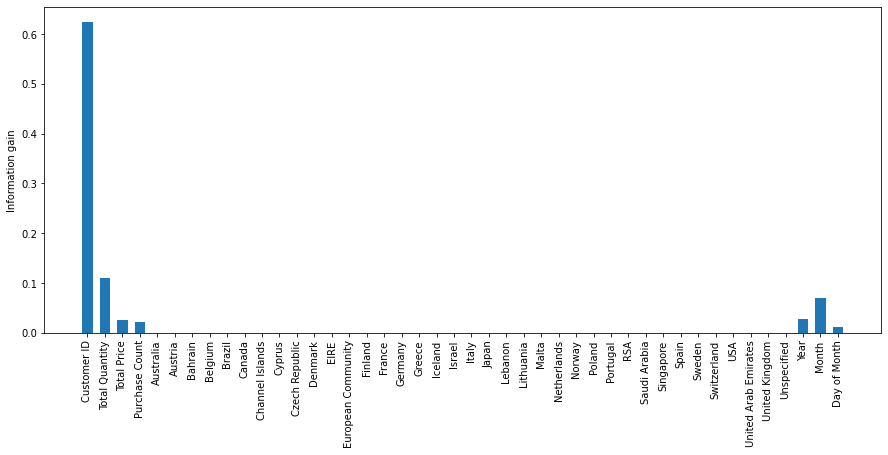

In [545]:
informationGains = informationGainCalc(features, labels)
x = [i for i in range(len(informationGains))]
plt.figure(figsize = (15, 6))
plt.bar(x, informationGains, width = 0.6)
plt.xticks(x, features.columns, rotation = 90)
plt.ylabel("Information gain")
plt.show()

In [518]:
features = features.drop("Customer ID", 1)

First of all we have to split the data to train dataset and test dataset. We use 80 percent of our dataset for training the model and the other 20 percent for testing. <br>
We train a model using training data and then predict target values for training data and test data. Finally we calculate accuracy, precision and recall by comparing the actual labels and the predicted ones. Our goal is to reach the best model without overfitting.

In [519]:
trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(features, labels, test_size = 0.2, random_state = 745)

The first classifier that we use is KNN. In KNN, K is the number of nearest neighbors. K is generally an odd number if the number of classes is even. K is one of the hyperparameters which we tune. We check different numbers and find the number of neighbors which maximizes the accuracy. In the case of a small number of neighbors, the noise will have a higher influence on the result, and a large number of neighbors make it computationally expensive. Research has also shown that a model with small amount of neighbors will have low bias but high variance, leading to overfitting. So the proper number of neighbors depends on the dataset but it's not extremely low or high values. <br>
As it can be seen in the plot, small number of neighbors leads to high accuracy for train data but low accuracy for test data which means high variance and happening of overfitting.

43 0.7665903890160183
KNN
----------------------------------
Train: 
Accuracy:  0.7416953035509737
Precision:  0.7291527070056327
Recall:  0.7416953035509737
Test: 
Accuracy:  0.7665903890160183
Precision:  0.7528576609521853
Recall:  0.7665903890160183

              precision    recall  f1-score   support

           0       0.66      0.42      0.51       257
           1       0.79      0.91      0.85       617

    accuracy                           0.77       874
   macro avg       0.73      0.66      0.68       874
weighted avg       0.75      0.77      0.75       874



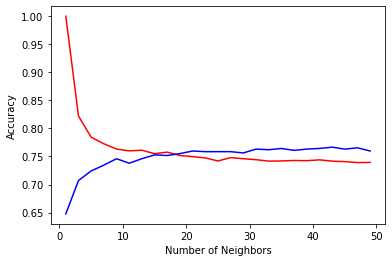

In [520]:
trainAccuracyList, testAccuracyList = helpFindBestKNN(trainFeatures, testFeatures, trainLabels, testLabels)
bestTestAccuracy = max(testAccuracyList)
bestNumOfNeighbors = 2 * testAccuracyList.index(bestTestAccuracy) + 1
print(bestNumOfNeighbors, bestTestAccuracy)
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 KNN(trainFeatures, testFeatures, trainLabels, testLabels, bestNumOfNeighbors)
print("KNN")
print("----------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)
numOfNeighbors = [2 * i + 1 for i in range(len(trainAccuracyList))]
plt.plot(numOfNeighbors, trainAccuracyList, 'r')
plt.plot(numOfNeighbors, testAccuracyList, 'b')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

Another classifier is Decision Tree. For this classifier, scaling is not necessary in the preprocess phase. One of the hyperparameters that needs to be tuned is maximum depth of the tree. If we don't tune this parameter, nodes are expanded until all leaves are pure. <br>
As it's shown in the plot, a higher value of maximum depth causes overfitting. Very low value of maximum depth also causes underfitting.

4 0.7700228832951945
Decision Tree
---------------------------------
Train: 
Accuracy:  0.7451317296678122
Precision:  0.7357844972395307
Recall:  0.7451317296678122
Test: 
Accuracy:  0.7700228832951945
Precision:  0.7569964923495712
Recall:  0.7700228832951945

              precision    recall  f1-score   support

           0       0.67      0.43      0.52       257
           1       0.79      0.91      0.85       617

    accuracy                           0.77       874
   macro avg       0.73      0.67      0.69       874
weighted avg       0.76      0.77      0.75       874



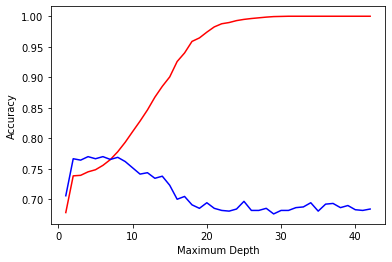

In [536]:
trainAccuracyList, testAccuracyList = helpFindBestDecisionTree(trainFeatures, testFeatures, trainLabels, testLabels)
bestTestAccuracy = max(testAccuracyList)
bestMaxDepth = testAccuracyList.index(bestTestAccuracy) + 1
print(bestMaxDepth, bestTestAccuracy)
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 decisionTree(trainFeatures, testFeatures, trainLabels, testLabels, bestMaxDepth)
print("Decision Tree")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)
maxDepth = [i + 1 for i in range(len(trainAccuracyList))]
plt.plot(maxDepth, trainAccuracyList, 'r')
plt.plot(maxDepth, testAccuracyList, 'b')
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.show()

The last classifier is Logistic Regression. It's a statistical method for predicting binary classes.

In [522]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 logisticRegression(trainFeatures, testFeatures, trainLabels, testLabels)
print("Logistic Regression")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Logistic Regression
---------------------------------
Train: 
Accuracy:  0.7296678121420389
Precision:  0.7156003341469516
Recall:  0.7296678121420389
Test: 
Accuracy:  0.7860411899313501
Precision:  0.7768111862469346
Recall:  0.7860411899313501

              precision    recall  f1-score   support

           0       0.67      0.53      0.59       257
           1       0.82      0.89      0.85       617

    accuracy                           0.79       874
   macro avg       0.75      0.71      0.72       874
weighted avg       0.78      0.79      0.78       874



Bagging is an ensemble algorithm that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions either by voting or by averaging, to form a final prediction. Bagging reduces overfitting because none of the classifiers have too much information about the training dataset. Also as the final prediction comes from voting or averaging, one overfitted classifier doesn't have much effect on the total result. <br>
The first base classifier used for bagging here, is the KNN that we modeled earlier in this CA.

In [523]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 baggingKNN(trainFeatures, testFeatures, trainLabels, testLabels, bestNumOfNeighbors)
print("Bagging KNN")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Bagging KNN
---------------------------------
Train: 
Accuracy:  0.7308132875143184
Precision:  0.7266273083575436
Recall:  0.7308132875143184
Test: 
Accuracy:  0.7540045766590389
Precision:  0.7400239575849474
Recall:  0.7540045766590389

              precision    recall  f1-score   support

           0       0.68      0.31      0.43       257
           1       0.77      0.94      0.84       617

    accuracy                           0.75       874
   macro avg       0.72      0.62      0.64       874
weighted avg       0.74      0.75      0.72       874



Another base classifier used for bagging in this CA, is the Decision Tree classifier with the maximum depth we tuned earlier.

In [537]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 baggingDecisionTree(trainFeatures, testFeatures, trainLabels, testLabels, bestMaxDepth)
print("Bagging Decision Tree")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Bagging Decision Tree
---------------------------------
Train: 
Accuracy:  0.7351088201603666
Precision:  0.7273819501871351
Recall:  0.7351088201603666
Test: 
Accuracy:  0.7643020594965675
Precision:  0.7515741345084666
Recall:  0.7643020594965675

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       257
           1       0.78      0.93      0.85       617

    accuracy                           0.76       874
   macro avg       0.73      0.65      0.66       874
weighted avg       0.75      0.76      0.74       874



A Random Forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control overfitting. <br>
Two hyperparameters which we try to understand the effect of them, are n_estimators and max_depth. n_estimators is the number of trees in the forest and max_depth is the maximum depth of the trees. <br>
First we use the maximum depth which we tuned earlier and 120 for number of trees.

In [538]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 randomForest(trainFeatures, testFeatures, trainLabels, testLabels, bestMaxDepth, 120)
print("Random Forest 1")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Random Forest 1
---------------------------------
Train: 
Accuracy:  0.6784077892325315
Precision:  0.4602371284913709
Recall:  0.6784077892325315
Test: 
Accuracy:  0.7059496567505721
Precision:  0.49836491786625053
Recall:  0.7059496567505721

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       257
           1       0.71      1.00      0.83       617

    accuracy                           0.71       874
   macro avg       0.35      0.50      0.41       874
weighted avg       0.50      0.71      0.58       874



Now we decrease the number of trees to 5. We see that precision increases, but it doesn't have much effect on accuracy and recall. By practice, we learn that high number of trees in a random forest causes lower accuracy, precision and recall. The more uncorrelated trees in our forest, the closer their individual errors get to averaging out.

In [539]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 randomForest(trainFeatures, testFeatures, trainLabels, testLabels, bestMaxDepth, 5)
print("Random Forest 2")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Random Forest 2
---------------------------------
Train: 
Accuracy:  0.6878579610538373
Precision:  0.7689819991414871
Recall:  0.6878579610538373
Test: 
Accuracy:  0.7059496567505721
Precision:  0.6467331850058925
Recall:  0.7059496567505721

              precision    recall  f1-score   support

           0       0.50      0.02      0.03       257
           1       0.71      0.99      0.83       617

    accuracy                           0.71       874
   macro avg       0.60      0.50      0.43       874
weighted avg       0.65      0.71      0.59       874



Now we increase the maximum depth of the trees to 13. This results in higher values of accuracy, precision and recall. By practice we see that extremely high values for maximum depth may result in overfitting.

In [540]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 randomForest(trainFeatures, testFeatures, trainLabels, testLabels, 13, 5)
print("Random Forest 3")
print("---------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Random Forest 3
---------------------------------
Train: 
Accuracy:  0.8233104238258877
Precision:  0.8253500835778593
Recall:  0.8233104238258877
Test: 
Accuracy:  0.7334096109839817
Precision:  0.7163527482452853
Recall:  0.7334096109839817

              precision    recall  f1-score   support

           0       0.56      0.41      0.48       257
           1       0.78      0.87      0.82       617

    accuracy                           0.73       874
   macro avg       0.67      0.64      0.65       874
weighted avg       0.72      0.73      0.72       874



In statistics, bootstrapping is any test or metric that relies on random sampling with replacement. Bootstrapping is the practice of estimating properties of an estimator (such as its variance) by measuring those properties when sampling from an approximating distribution. The basic idea of bootstrapping is that inference about a population from sample data (sample → population) can be modelled by resampling the sample data and performing inference about a sample from resampled data (resampled → sample). --Wikipedia <br>
Bootstrapping reduces variance and increases bias.

In a Voting Classifier, different classifiers have the same training dataset. We aggregate the predictions of each classifier and predict the class that gets the most votes.

In [541]:
trainAccuracy, trainPrecision, trainRecall, accuracy, precision, recall, rep =\
 hardVoting(trainFeatures, testFeatures, trainLabels, testLabels, bestNumOfNeighbors, bestMaxDepth)
print("Hard Voting")
print("--------------------------------")
print("Train: ")
print("Accuracy: ", trainAccuracy)
print("Precision: ", trainPrecision)
print("Recall: ", trainRecall)
print("Test: ")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print()
print(rep)

Hard Voting
--------------------------------
Train: 
Accuracy:  0.7425544100801833
Precision:  0.7303204413517165
Recall:  0.7425544100801833
Test: 
Accuracy:  0.7791762013729977
Precision:  0.7678801200903308
Recall:  0.7791762013729977

              precision    recall  f1-score   support

           0       0.68      0.46      0.55       257
           1       0.80      0.91      0.85       617

    accuracy                           0.78       874
   macro avg       0.74      0.69      0.70       874
weighted avg       0.77      0.78      0.76       874



If we compare the results with the single classifiers in phase 1, we see that the results are not better. The initial dataset is imbalanced, so the single classifiers mostly predict one specific class and the features are also limited. As a result, ensemble methods including the hard-voting classifier, also predict that one class most of the times. So it can't do any better than the single classifiers.